In [ ]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes torch spacy hdbscan umap-learn scikit-learn
!python -m spacy download en_core_web_lg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.4 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [6]:
# =========================
# 1. Imports and Setup
# =========================

import os
import pandas as pd
import numpy as np
import json
import re, string
import unicodedata
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import torch
from sklearn.cluster import KMeans

from llama_index.core import Settings, Document, StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy

from sentence_transformers import SentenceTransformer     # or use TF-IDF if you prefer
# Dimensionality reduction & clustering
import umap.umap_ as umap
import seaborn as sns
import hdbscan
from concurrent.futures import ThreadPoolExecutor, as_completed

In [7]:
# =========================
# 2. Configuration
# =========================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
base_path = "/home/anton/jupyter-env/nlp-project"
os.chdir(base_path)

# print pwd
print("Current working directory:", os.getcwd())

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tqdm.pandas()

model_name_embed = "sentence-transformers/all-MiniLM-L6-v2"
model_name_llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
chunk_size = 200
persist_dir = "storage2"

# Switch: Use vector DB or not
USE_VECTOR_DB = True  # Set to False to run agent without vector DB

Device: cuda
Current working directory: /home/anton/jupyter-env/nlp-project


[nltk_data] Downloading package punkt to /home/anton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# =========================
# 3. Data Loading & Filtering
# =========================

metadata_path = "metadata.csv"
metadata = pd.read_csv(metadata_path, dtype=str)

smoking_keywords = [
    "smoking", "smoker", "smoke", "ecigarett", "cigarett", "tobacco", "cigarette", "nicotine",
    "vaping", "vape", "e-cigarette", "cigar", "weed", "marijuana"
]
covid_terms = ["covid", "sars-cov-2", "coronavirus"]

columns_to_keep = ['cord_uid', 'title', 'abstract', 'publish_time', 'source_x', 'authors', 'pdf_json_files', 'pmc_json_files']
metadata = metadata[columns_to_keep]

In [9]:
# remove rows with NaN in 'abstract' or 'title', pdf_json_files
metadata = metadata.dropna(subset=['abstract', 'title', 'pdf_json_files'])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326684 entries, 0 to 1056659
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cord_uid        326684 non-null  object
 1   title           326684 non-null  object
 2   abstract        326684 non-null  object
 3   publish_time    326684 non-null  object
 4   source_x        326684 non-null  object
 5   authors         325854 non-null  object
 6   pdf_json_files  326684 non-null  object
 7   pmc_json_files  263444 non-null  object
dtypes: object(8)
memory usage: 22.4+ MB


In [ ]:
# =========================
# 4. Text Extraction & Preprocessing
# =========================

# def extract_body_text(json_path):
#     try:
#         with open(json_path, 'r') as f:
#             data = json.load(f)
#         return ' '.join(para['text'] for para in data.get('body_text', []))
#     except Exception:
#         return None

# def get_full_text(row):
#     if pd.notna(row['pdf_json_files']):
#         for json_path in row['pdf_json_files'].split('; '):
#             full_path = os.path.join(base_path, json_path.strip())
#             if os.path.exists(full_path):
#                 return extract_body_text(full_path)
#     return None

# tqdm.pandas(desc="Extracting full text sections")
# metadata['full_text'] = metadata.progress_apply(get_full_text, axis=1)

# metadata = metadata.dropna(subset=['title', 'abstract', 'full_text'])

punct_table = str.maketrans("", "", string.punctuation)
def clean_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\$.*?\$", " ", text)
    text = re.sub(r"\[\d+\]|\(\d+\)", " ", text)
    text = re.sub(r"[^\x20-\x7E]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower().strip()
    text = text.translate(punct_table)
    return text

output_csv = "metadata_with_text.csv"

# Ensure output file is fresh
if os.path.exists(output_csv):
    os.remove(output_csv)

# Write header to output file
columns_to_save = ['cord_uid', 'title', 'abstract', 'pdf_json_files', 'full_text']
with open(output_csv, 'w', encoding='utf-8') as f:
    f.write(','.join(columns_to_save) + '\n')

# Extract body text
def extract_body_text(json_path):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        concatenated = ' '.join(para['text'] for para in data.get('body_text', []) if 'text' in para)
        return clean_text(concatenated)
    except Exception as e:
        print(f"Error reading {json_path}: {e}")
        return None

# Process each row
for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Processing rows"):
    try:
        if pd.notna(row['pdf_json_files']):
            full_texts = []
            for json_path in re.split(r';\s*', row['pdf_json_files']):
                full_path = os.path.join(base_path, json_path.strip())
                if os.path.exists(full_path):
                    text = extract_body_text(full_path)
                    if text:
                        full_texts.append(text)
            full_text = ' '.join(full_texts).replace('\n', ' ').strip()
        else:
            full_text = None

        if pd.notna(row['title']) and pd.notna(row['abstract']) and full_text:
            # Write row to CSV
            row_data = [
                str(row['cord_uid']),
                str(row['title']).replace('\n', ' ').replace('"', "'"),
                str(row['abstract']).replace('\n', ' ').replace('"', "'"),
                str(row['pdf_json_files']).replace('\n', ' '),
                full_text.replace('"', "'")
            ]
            with open(output_csv, 'a', encoding='utf-8') as f_out:
                f_out.write(','.join(f'"{item}"' for item in row_data) + '\n')


    except Exception as e:
        print(f"Error processing row {idx}: {e}")



Processing rows: 100%|█████████████████████████████████████████████████████████| 326684/326684 [23:27<00:00, 232.17it/s]


In [ ]:
# =========================
# 5. Read external papers. {name: text, name: text, ...}
# =========================

external_papers_path = "extracted_texts.json"
if os.path.exists(external_papers_path):
    with open(external_papers_path, 'r') as f:
        external_papers = json.load(f)
else:
    external_papers = {}


new_rows = []
for name, text in external_papers.items():
    new_rows.append({
        'cord_uid': name,
        'title': name,
        'full_text': text
    })

# Convert to DataFrame with the same columns as metadata
new_df = pd.DataFrame(new_rows)


# Add any missing columns from metadata with None values
for col in metadata.columns:
    if col not in new_df.columns:
        new_df[col] = None

# Concatenate the DataFrames
extended_papers = pd.concat([metadata, new_df], ignore_index=True)

# print last 5 rows of the extended_papers DataFrame
print(extended_papers.tail())

                            cord_uid                           title abstract  \
4460       NDIGOC092507_2020_004.pdf       NDIGOC092507_2020_004.pdf     None   
4461          s41598-021-98749-4.pdf          s41598-021-98749-4.pdf     None   
4462  2020.06.01.20118877v2.full.pdf  2020.06.01.20118877v2.full.pdf     None   
4463          s42003-021-02685-y.pdf          s42003-021-02685-y.pdf     None   
4464                      VGJCUN.pdf                      VGJCUN.pdf     None   

     publish_time source_x authors pdf_json_files pmc_json_files full_text  \
4460         None     None    None           None           None      None   
4461         None     None    None           None           None      None   
4462         None     None    None           None           None      None   
4463         None     None    None           None           None      None   
4464         None     None    None           None           None      None   

                                          co

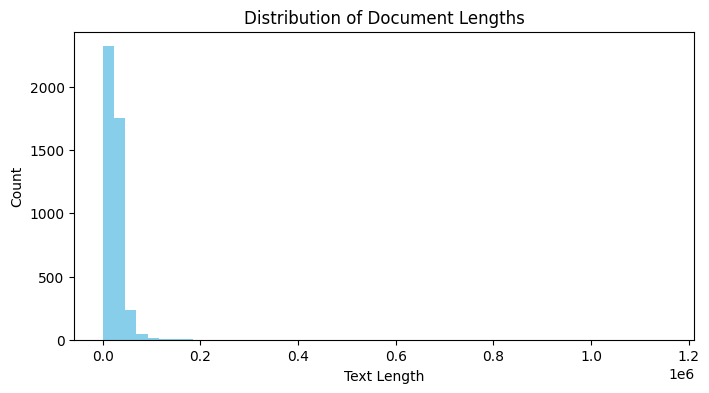

In [ ]:
# --- Outlier Detection (Text Length) ---
plt.figure(figsize=(8, 4))
plt.hist(extended_papers['full_text'].str.len(), bins=50, color='skyblue')
plt.title("Distribution of Document Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [ ]:
# How many uniques characters in the combined_text?
unique_chars = set(''.join(extended_papers['full_text'].dropna()))
sorted_unique_chars = sorted(unique_chars)
print(f"Number of unique characters in combined_text: {len(sorted_unique_chars)}")
print("Unique characters in combined_text:", sorted_unique_chars)

Number of unique characters in combined_text: 37
Unique characters in combined_text: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# count in each row character and wors, create new columns
extended_papers['text_length'] = extended_papers['full_text'].str.len()
extended_papers['word_count'] = extended_papers['full_text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
# print statustics of the text_length and word_count columns
print("Text Length Statistics:")
print(extended_papers['text_length'].describe())
print("Word Count Statistics:")
print(extended_papers['word_count'].describe())

Text Length Statistics:
count      4465.000000
mean      22968.145353
std       15044.415363
min        1106.000000
25%       13953.000000
50%       20734.000000
75%       28407.000000
max      362733.000000
Name: text_length, dtype: float64
Word Count Statistics:
count     4465.000000
mean      3566.713774
std       2331.585840
min        169.000000
25%       2170.000000
50%       3227.000000
75%       4407.000000
max      55958.000000
Name: word_count, dtype: float64


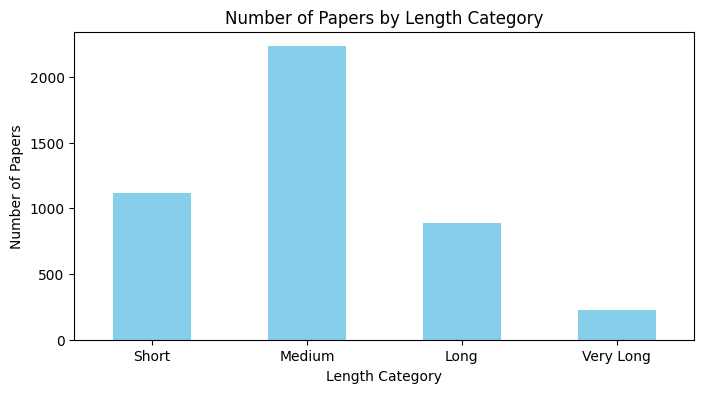

In [57]:
# Create a diagram of the text length and word count grouped by statistics under 25%, between 25% and 75%, above 75%, and very long above 95%
q25 = extended_papers['text_length'].quantile(0.25)
q75 = extended_papers['text_length'].quantile(0.75)
q95 = extended_papers['text_length'].quantile(0.95)

def categorize_length(row):
    if row['text_length'] > q95:
        return 'Very Long'
    elif row['text_length'] > q75:
        return 'Long'
    elif row['text_length'] < q25:
        return 'Short'
    else:
        return 'Medium'

extended_papers['length_category'] = extended_papers.apply(categorize_length, axis=1)
# Count the number of papers in each category
length_counts = extended_papers['length_category'].value_counts().reindex(['Short', 'Medium', 'Long', 'Very Long'])
# Plot the counts
plt.figure(figsize=(8, 4))
length_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Papers by Length Category")
plt.xlabel("Length Category")
plt.ylabel("Number of Papers")
plt.xticks(rotation=0)
plt.show()

In [58]:
# leave only rows with text length more than 1000 characters and less than 40000 characters
extended_papers = extended_papers[
    (extended_papers['text_length'] > 1000) & (extended_papers['text_length'] < 40000)
]
extended_papers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4072 entries, 0 to 4464
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cord_uid         4072 non-null   object
 1   title            4072 non-null   object
 2   abstract         4001 non-null   object
 3   publish_time     4001 non-null   object
 4   source_x         4001 non-null   object
 5   authors          3995 non-null   object
 6   pdf_json_files   4001 non-null   object
 7   pmc_json_files   3347 non-null   object
 8   full_text        4001 non-null   object
 9   combined_text    4072 non-null   object
 10  text_length      4072 non-null   int64 
 11  word_count       4072 non-null   int64 
 12  length_category  4072 non-null   object
dtypes: int64(2), object(11)
memory usage: 445.4+ KB


In [ ]:
# export to CSV
extended_papers.to_csv("extended_papers_cleaned.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

df = extended_papers.copy()
df['combined_text'] = (
    df['title'].fillna('') + '. ' +
    df['abstract'].fillna('') + '. ' +
    df['full_text'].fillna('')
)

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create topic embeddings
smoking_topic = " ".join(smoking_keywords)
covid_topic = " ".join(covid_keywords)
topic_embeddings = model.encode([smoking_topic, covid_topic])

# Get article embeddings
article_embeddings = model.encode(df['combined_text'].tolist())

# Calculate similarities
similarities = cosine_similarity(article_embeddings, topic_embeddings)
df['smoking_similarity'] = similarities[:, 0]
df['covid_similarity'] = similarities[:, 1]

# Categorize articles
threshold = 0.3
def categorize_article(row):
    smoking = row['smoking_similarity'] > threshold
    covid = row['covid_similarity'] > threshold
    
    if smoking and covid:
        return "Both"
    elif smoking:
        return "Smoking"
    elif covid:
        return "COVID"
    else:
        return "Other"

df['category'] = df.apply(categorize_article, axis=1)

# UMAP visualization
# Reduce dimensions with UMAP
umap_2d = UMAP(n_components=2, random_state=42)
umap_3d = UMAP(n_components=3, random_state=42)

# Fit and transform
projections_2d = umap_2d.fit_transform(article_embeddings)
projections_3d = umap_3d.fit_transform(article_embeddings)

# Add to dataframe
df['x'] = projections_2d[:, 0]
df['y'] = projections_2d[:, 1]
df['z'] = projections_3d[:, 2]

# Create color palette
palette = {'Smoking': 'red', 'COVID': 'blue', 'Both': 'purple', 'Other': 'gray'}

# 2D Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y',
    hue='category',
    palette=palette,
    data=df,
    s=100,
    alpha=0.8
)

# Add text labels
for line in range(0, df.shape[0]):
    plt.text(df['x'][line]+0.02, df['y'][line], 
             df['title'][line][:50], 
             horizontalalignment='left', 
             size='medium', 
             color='black')

plt.title('UMAP Projection of Article Clusters (2D)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Article Category')
plt.show()

# 3D Plot (optional)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for category, color in palette.items():
    subset = df[df['category'] == category]
    ax.scatter(
        subset['x'],
        subset['y'],
        subset['z'],
        c=color,
        label=category,
        s=100,
        alpha=0.8
    )

# Add text labels
for line in range(0, df.shape[0]):
    ax.text(df['x'][line], df['y'][line], df['z'][line], 
            f"{df['title'][line][:50]}", 
            size=10, zorder=1, color='k')

ax.set_title('UMAP Projection of Article Clusters (3D)')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.legend()
plt.show()